In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.87
Loading CCF brain structure data...
Loading time: 0.00


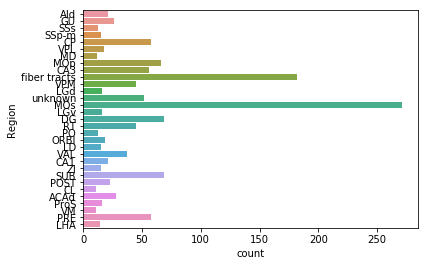

In [2]:
sf = ns.features['soma_features'].region
ct = sf["Region"].value_counts().sort_values(ascending=False)
_ = sns.countplot(y="Region", 
                  data=sf.loc[sf.Region.isin(ct.index[ct>10])],
                 )

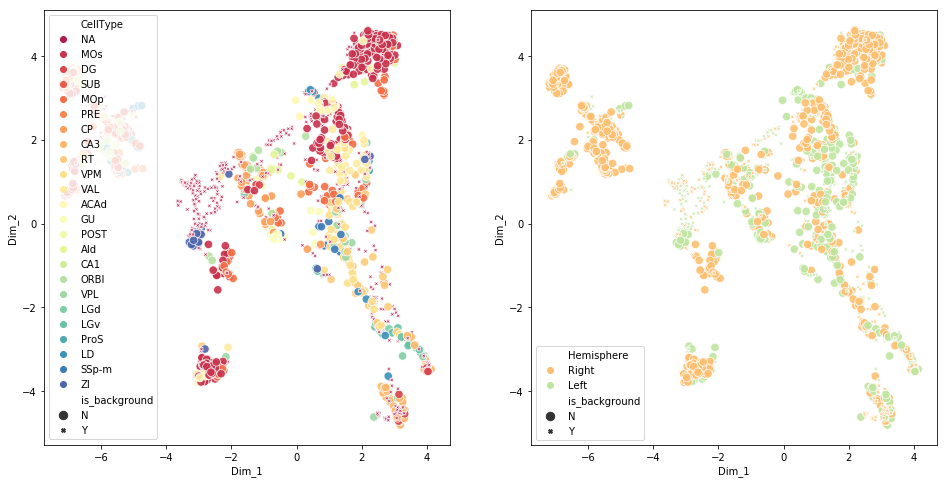

In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)
_ = ns.FeatureScatter(["CellType", "Hemisphere"], map="UMAP")

### Speed of parallel
* for an array testA = nmt.annotation.array[55:90,120:167,179:231].copy()
    * There are 85540 points inside
    * Takes 29.143057346343994 second to run the code.
* For the original array
    * There are 77045760 points inside
    * It may take about 7.25 hours to store all the point. We will try that this evening.

In [4]:
x_block = [range(nmt.annotation.array.shape[0])[i:i + 30] for i in range(0, nmt.annotation.array.shape[0], 30)]
y_block = [range(nmt.annotation.array.shape[1])[i:i + 30] for i in range(0, nmt.annotation.array.shape[1], 30)]
z_block = [range(nmt.annotation.array.shape[2])[i:i + 30] for i in range(0, nmt.annotation.array.shape[2], 30)]

In [5]:
import multiprocessing
import time
def Contour_block6(Temp_arr,x_lower,x_upper,y_lower,y_upper,z_lower,z_upper):#,x_s,y_s,z_s):
    mask_Temp = np.zeros((Temp_arr.shape)) 
    mask_Temp[x_lower:x_upper,y_lower:y_upper,z_lower:z_upper]=1
    
    co_1,co_2,co_3 = np.where(np.multiply(mask_Temp,Temp_arr)!=0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        x2yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        xy1z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xy2z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xyz1 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        xyz2 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2]):
            #print(str([centerV,x1yz,x2yz,xy1z,xy2z,xyz1,xyz2]))
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
temp_array = nmt.annotation.array.copy()
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            x_l = iter_X[0]
            x_u = iter_X[-1]+1
            y_l = iter_Y[0]
            y_u = iter_Y[-1]+1
            z_l = iter_Z[0]
            z_u = iter_Z[-1]+1

            result_list.append(Contour_block6(temp_array,x_l,x_u,y_l,y_u,z_l,z_u))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))



X range: 0:30; Y range: 0:30; Z range: 0:30
X range: 0:30; Y range: 0:30; Z range: 30:60
X range: 0:30; Y range: 0:30; Z range: 60:90
X range: 0:30; Y range: 0:30; Z range: 90:120
X range: 0:30; Y range: 0:30; Z range: 120:150
X range: 0:30; Y range: 0:30; Z range: 150:180
X range: 0:30; Y range: 0:30; Z range: 180:210
X range: 0:30; Y range: 0:30; Z range: 210:240
X range: 0:30; Y range: 0:30; Z range: 240:270
X range: 0:30; Y range: 0:30; Z range: 270:300
X range: 0:30; Y range: 0:30; Z range: 300:330
X range: 0:30; Y range: 0:30; Z range: 330:360
X range: 0:30; Y range: 0:30; Z range: 360:390
X range: 0:30; Y range: 0:30; Z range: 390:420
X range: 0:30; Y range: 0:30; Z range: 420:450
X range: 0:30; Y range: 0:30; Z range: 450:456
X range: 0:30; Y range: 30:60; Z range: 0:30
X range: 0:30; Y range: 30:60; Z range: 30:60
X range: 0:30; Y range: 30:60; Z range: 60:90
X range: 0:30; Y range: 30:60; Z range: 90:120
X range: 0:30; Y range: 30:60; Z range: 120:150
X range: 0:30; Y range: 

X range: 0:30; Y range: 300:320; Z range: 270:300
X range: 0:30; Y range: 300:320; Z range: 300:330
X range: 0:30; Y range: 300:320; Z range: 330:360
X range: 0:30; Y range: 300:320; Z range: 360:390
X range: 0:30; Y range: 300:320; Z range: 390:420
X range: 0:30; Y range: 300:320; Z range: 420:450
X range: 0:30; Y range: 300:320; Z range: 450:456
X range: 30:60; Y range: 0:30; Z range: 0:30
X range: 30:60; Y range: 0:30; Z range: 30:60
X range: 30:60; Y range: 0:30; Z range: 60:90
X range: 30:60; Y range: 0:30; Z range: 90:120
X range: 30:60; Y range: 0:30; Z range: 120:150
X range: 30:60; Y range: 0:30; Z range: 150:180
X range: 30:60; Y range: 0:30; Z range: 180:210
X range: 30:60; Y range: 0:30; Z range: 210:240
X range: 30:60; Y range: 0:30; Z range: 240:270
X range: 30:60; Y range: 0:30; Z range: 270:300
X range: 30:60; Y range: 0:30; Z range: 300:330
X range: 30:60; Y range: 0:30; Z range: 330:360
X range: 30:60; Y range: 0:30; Z range: 360:390
X range: 30:60; Y range: 0:30; Z r

X range: 30:60; Y range: 270:300; Z range: 420:450
X range: 30:60; Y range: 270:300; Z range: 450:456
X range: 30:60; Y range: 300:320; Z range: 0:30
X range: 30:60; Y range: 300:320; Z range: 30:60
X range: 30:60; Y range: 300:320; Z range: 60:90
X range: 30:60; Y range: 300:320; Z range: 90:120
X range: 30:60; Y range: 300:320; Z range: 120:150
X range: 30:60; Y range: 300:320; Z range: 150:180
X range: 30:60; Y range: 300:320; Z range: 180:210
X range: 30:60; Y range: 300:320; Z range: 210:240
X range: 30:60; Y range: 300:320; Z range: 240:270
X range: 30:60; Y range: 300:320; Z range: 270:300
X range: 30:60; Y range: 300:320; Z range: 300:330
X range: 30:60; Y range: 300:320; Z range: 330:360
X range: 30:60; Y range: 300:320; Z range: 360:390
X range: 30:60; Y range: 300:320; Z range: 390:420
X range: 30:60; Y range: 300:320; Z range: 420:450
X range: 30:60; Y range: 300:320; Z range: 450:456
X range: 60:90; Y range: 0:30; Z range: 0:30
X range: 60:90; Y range: 0:30; Z range: 30:60

X range: 60:90; Y range: 270:300; Z range: 90:120
X range: 60:90; Y range: 270:300; Z range: 120:150
X range: 60:90; Y range: 270:300; Z range: 150:180
X range: 60:90; Y range: 270:300; Z range: 180:210
X range: 60:90; Y range: 270:300; Z range: 210:240
X range: 60:90; Y range: 270:300; Z range: 240:270
X range: 60:90; Y range: 270:300; Z range: 270:300
X range: 60:90; Y range: 270:300; Z range: 300:330
X range: 60:90; Y range: 270:300; Z range: 330:360
X range: 60:90; Y range: 270:300; Z range: 360:390
X range: 60:90; Y range: 270:300; Z range: 390:420
X range: 60:90; Y range: 270:300; Z range: 420:450
X range: 60:90; Y range: 270:300; Z range: 450:456
X range: 60:90; Y range: 300:320; Z range: 0:30
X range: 60:90; Y range: 300:320; Z range: 30:60
X range: 60:90; Y range: 300:320; Z range: 60:90
X range: 60:90; Y range: 300:320; Z range: 90:120
X range: 60:90; Y range: 300:320; Z range: 120:150
X range: 60:90; Y range: 300:320; Z range: 150:180
X range: 60:90; Y range: 300:320; Z rang

X range: 90:120; Y range: 240:270; Z range: 180:210
X range: 90:120; Y range: 240:270; Z range: 210:240
X range: 90:120; Y range: 240:270; Z range: 240:270
X range: 90:120; Y range: 240:270; Z range: 270:300
X range: 90:120; Y range: 240:270; Z range: 300:330
X range: 90:120; Y range: 240:270; Z range: 330:360
X range: 90:120; Y range: 240:270; Z range: 360:390
X range: 90:120; Y range: 240:270; Z range: 390:420
X range: 90:120; Y range: 240:270; Z range: 420:450
X range: 90:120; Y range: 240:270; Z range: 450:456
X range: 90:120; Y range: 270:300; Z range: 0:30
X range: 90:120; Y range: 270:300; Z range: 30:60
X range: 90:120; Y range: 270:300; Z range: 60:90
X range: 90:120; Y range: 270:300; Z range: 90:120
X range: 90:120; Y range: 270:300; Z range: 120:150
X range: 90:120; Y range: 270:300; Z range: 150:180
X range: 90:120; Y range: 270:300; Z range: 180:210
X range: 90:120; Y range: 270:300; Z range: 210:240
X range: 90:120; Y range: 270:300; Z range: 240:270
X range: 90:120; Y r

X range: 120:150; Y range: 210:240; Z range: 180:210
X range: 120:150; Y range: 210:240; Z range: 210:240
X range: 120:150; Y range: 210:240; Z range: 240:270
X range: 120:150; Y range: 210:240; Z range: 270:300
X range: 120:150; Y range: 210:240; Z range: 300:330
X range: 120:150; Y range: 210:240; Z range: 330:360
X range: 120:150; Y range: 210:240; Z range: 360:390
X range: 120:150; Y range: 210:240; Z range: 390:420
X range: 120:150; Y range: 210:240; Z range: 420:450
X range: 120:150; Y range: 210:240; Z range: 450:456
X range: 120:150; Y range: 240:270; Z range: 0:30
X range: 120:150; Y range: 240:270; Z range: 30:60
X range: 120:150; Y range: 240:270; Z range: 60:90
X range: 120:150; Y range: 240:270; Z range: 90:120
X range: 120:150; Y range: 240:270; Z range: 120:150
X range: 120:150; Y range: 240:270; Z range: 150:180
X range: 120:150; Y range: 240:270; Z range: 180:210
X range: 120:150; Y range: 240:270; Z range: 210:240
X range: 120:150; Y range: 240:270; Z range: 240:270
X

X range: 150:180; Y range: 180:210; Z range: 150:180
X range: 150:180; Y range: 180:210; Z range: 180:210
X range: 150:180; Y range: 180:210; Z range: 210:240
X range: 150:180; Y range: 180:210; Z range: 240:270
X range: 150:180; Y range: 180:210; Z range: 270:300
X range: 150:180; Y range: 180:210; Z range: 300:330
X range: 150:180; Y range: 180:210; Z range: 330:360
X range: 150:180; Y range: 180:210; Z range: 360:390
X range: 150:180; Y range: 180:210; Z range: 390:420
X range: 150:180; Y range: 180:210; Z range: 420:450
X range: 150:180; Y range: 180:210; Z range: 450:456
X range: 150:180; Y range: 210:240; Z range: 0:30
X range: 150:180; Y range: 210:240; Z range: 30:60
X range: 150:180; Y range: 210:240; Z range: 60:90
X range: 150:180; Y range: 210:240; Z range: 90:120
X range: 150:180; Y range: 210:240; Z range: 120:150
X range: 150:180; Y range: 210:240; Z range: 150:180
X range: 150:180; Y range: 210:240; Z range: 180:210
X range: 150:180; Y range: 210:240; Z range: 210:240
X

X range: 180:210; Y range: 150:180; Z range: 120:150
X range: 180:210; Y range: 150:180; Z range: 150:180
X range: 180:210; Y range: 150:180; Z range: 180:210
X range: 180:210; Y range: 150:180; Z range: 210:240
X range: 180:210; Y range: 150:180; Z range: 240:270
X range: 180:210; Y range: 150:180; Z range: 270:300
X range: 180:210; Y range: 150:180; Z range: 300:330
X range: 180:210; Y range: 150:180; Z range: 330:360
X range: 180:210; Y range: 150:180; Z range: 360:390
X range: 180:210; Y range: 150:180; Z range: 390:420
X range: 180:210; Y range: 150:180; Z range: 420:450
X range: 180:210; Y range: 150:180; Z range: 450:456
X range: 180:210; Y range: 180:210; Z range: 0:30
X range: 180:210; Y range: 180:210; Z range: 30:60
X range: 180:210; Y range: 180:210; Z range: 60:90
X range: 180:210; Y range: 180:210; Z range: 90:120
X range: 180:210; Y range: 180:210; Z range: 120:150
X range: 180:210; Y range: 180:210; Z range: 150:180
X range: 180:210; Y range: 180:210; Z range: 180:210
X

X range: 210:240; Y range: 120:150; Z range: 90:120
X range: 210:240; Y range: 120:150; Z range: 120:150
X range: 210:240; Y range: 120:150; Z range: 150:180
X range: 210:240; Y range: 120:150; Z range: 180:210
X range: 210:240; Y range: 120:150; Z range: 210:240
X range: 210:240; Y range: 120:150; Z range: 240:270
X range: 210:240; Y range: 120:150; Z range: 270:300
X range: 210:240; Y range: 120:150; Z range: 300:330
X range: 210:240; Y range: 120:150; Z range: 330:360
X range: 210:240; Y range: 120:150; Z range: 360:390
X range: 210:240; Y range: 120:150; Z range: 390:420
X range: 210:240; Y range: 120:150; Z range: 420:450
X range: 210:240; Y range: 120:150; Z range: 450:456
X range: 210:240; Y range: 150:180; Z range: 0:30
X range: 210:240; Y range: 150:180; Z range: 30:60
X range: 210:240; Y range: 150:180; Z range: 60:90
X range: 210:240; Y range: 150:180; Z range: 90:120
X range: 210:240; Y range: 150:180; Z range: 120:150
X range: 210:240; Y range: 150:180; Z range: 150:180
X 

X range: 240:270; Y range: 90:120; Z range: 60:90
X range: 240:270; Y range: 90:120; Z range: 90:120
X range: 240:270; Y range: 90:120; Z range: 120:150
X range: 240:270; Y range: 90:120; Z range: 150:180
X range: 240:270; Y range: 90:120; Z range: 180:210
X range: 240:270; Y range: 90:120; Z range: 210:240
X range: 240:270; Y range: 90:120; Z range: 240:270
X range: 240:270; Y range: 90:120; Z range: 270:300
X range: 240:270; Y range: 90:120; Z range: 300:330
X range: 240:270; Y range: 90:120; Z range: 330:360
X range: 240:270; Y range: 90:120; Z range: 360:390
X range: 240:270; Y range: 90:120; Z range: 390:420
X range: 240:270; Y range: 90:120; Z range: 420:450
X range: 240:270; Y range: 90:120; Z range: 450:456
X range: 240:270; Y range: 120:150; Z range: 0:30
X range: 240:270; Y range: 120:150; Z range: 30:60
X range: 240:270; Y range: 120:150; Z range: 60:90
X range: 240:270; Y range: 120:150; Z range: 90:120
X range: 240:270; Y range: 120:150; Z range: 120:150
X range: 240:270; 

X range: 270:300; Y range: 60:90; Z range: 0:30
X range: 270:300; Y range: 60:90; Z range: 30:60
X range: 270:300; Y range: 60:90; Z range: 60:90
X range: 270:300; Y range: 60:90; Z range: 90:120
X range: 270:300; Y range: 60:90; Z range: 120:150
X range: 270:300; Y range: 60:90; Z range: 150:180
X range: 270:300; Y range: 60:90; Z range: 180:210
X range: 270:300; Y range: 60:90; Z range: 210:240
X range: 270:300; Y range: 60:90; Z range: 240:270
X range: 270:300; Y range: 60:90; Z range: 270:300
X range: 270:300; Y range: 60:90; Z range: 300:330
X range: 270:300; Y range: 60:90; Z range: 330:360
X range: 270:300; Y range: 60:90; Z range: 360:390
X range: 270:300; Y range: 60:90; Z range: 390:420
X range: 270:300; Y range: 60:90; Z range: 420:450
X range: 270:300; Y range: 60:90; Z range: 450:456
X range: 270:300; Y range: 90:120; Z range: 0:30
X range: 270:300; Y range: 90:120; Z range: 30:60
X range: 270:300; Y range: 90:120; Z range: 60:90
X range: 270:300; Y range: 90:120; Z range:

X range: 300:330; Y range: 0:30; Z range: 420:450
X range: 300:330; Y range: 0:30; Z range: 450:456
X range: 300:330; Y range: 30:60; Z range: 0:30
X range: 300:330; Y range: 30:60; Z range: 30:60
X range: 300:330; Y range: 30:60; Z range: 60:90
X range: 300:330; Y range: 30:60; Z range: 90:120
X range: 300:330; Y range: 30:60; Z range: 120:150
X range: 300:330; Y range: 30:60; Z range: 150:180
X range: 300:330; Y range: 30:60; Z range: 180:210
X range: 300:330; Y range: 30:60; Z range: 210:240
X range: 300:330; Y range: 30:60; Z range: 240:270
X range: 300:330; Y range: 30:60; Z range: 270:300
X range: 300:330; Y range: 30:60; Z range: 300:330
X range: 300:330; Y range: 30:60; Z range: 330:360
X range: 300:330; Y range: 30:60; Z range: 360:390
X range: 300:330; Y range: 30:60; Z range: 390:420
X range: 300:330; Y range: 30:60; Z range: 420:450
X range: 300:330; Y range: 30:60; Z range: 450:456
X range: 300:330; Y range: 60:90; Z range: 0:30
X range: 300:330; Y range: 60:90; Z range: 3

X range: 300:330; Y range: 300:320; Z range: 360:390
X range: 300:330; Y range: 300:320; Z range: 390:420
X range: 300:330; Y range: 300:320; Z range: 420:450
X range: 300:330; Y range: 300:320; Z range: 450:456
X range: 330:360; Y range: 0:30; Z range: 0:30
X range: 330:360; Y range: 0:30; Z range: 30:60
X range: 330:360; Y range: 0:30; Z range: 60:90
X range: 330:360; Y range: 0:30; Z range: 90:120
X range: 330:360; Y range: 0:30; Z range: 120:150
X range: 330:360; Y range: 0:30; Z range: 150:180
X range: 330:360; Y range: 0:30; Z range: 180:210
X range: 330:360; Y range: 0:30; Z range: 210:240
X range: 330:360; Y range: 0:30; Z range: 240:270
X range: 330:360; Y range: 0:30; Z range: 270:300
X range: 330:360; Y range: 0:30; Z range: 300:330
X range: 330:360; Y range: 0:30; Z range: 330:360
X range: 330:360; Y range: 0:30; Z range: 360:390
X range: 330:360; Y range: 0:30; Z range: 390:420
X range: 330:360; Y range: 0:30; Z range: 420:450
X range: 330:360; Y range: 0:30; Z range: 450:

X range: 330:360; Y range: 270:300; Z range: 330:360
X range: 330:360; Y range: 270:300; Z range: 360:390
X range: 330:360; Y range: 270:300; Z range: 390:420
X range: 330:360; Y range: 270:300; Z range: 420:450
X range: 330:360; Y range: 270:300; Z range: 450:456
X range: 330:360; Y range: 300:320; Z range: 0:30
X range: 330:360; Y range: 300:320; Z range: 30:60
X range: 330:360; Y range: 300:320; Z range: 60:90
X range: 330:360; Y range: 300:320; Z range: 90:120
X range: 330:360; Y range: 300:320; Z range: 120:150
X range: 330:360; Y range: 300:320; Z range: 150:180
X range: 330:360; Y range: 300:320; Z range: 180:210
X range: 330:360; Y range: 300:320; Z range: 210:240
X range: 330:360; Y range: 300:320; Z range: 240:270
X range: 330:360; Y range: 300:320; Z range: 270:300
X range: 330:360; Y range: 300:320; Z range: 300:330
X range: 330:360; Y range: 300:320; Z range: 330:360
X range: 330:360; Y range: 300:320; Z range: 360:390
X range: 330:360; Y range: 300:320; Z range: 390:420
X

X range: 360:390; Y range: 240:270; Z range: 300:330
X range: 360:390; Y range: 240:270; Z range: 330:360
X range: 360:390; Y range: 240:270; Z range: 360:390
X range: 360:390; Y range: 240:270; Z range: 390:420
X range: 360:390; Y range: 240:270; Z range: 420:450
X range: 360:390; Y range: 240:270; Z range: 450:456
X range: 360:390; Y range: 270:300; Z range: 0:30
X range: 360:390; Y range: 270:300; Z range: 30:60
X range: 360:390; Y range: 270:300; Z range: 60:90
X range: 360:390; Y range: 270:300; Z range: 90:120
X range: 360:390; Y range: 270:300; Z range: 120:150
X range: 360:390; Y range: 270:300; Z range: 150:180
X range: 360:390; Y range: 270:300; Z range: 180:210
X range: 360:390; Y range: 270:300; Z range: 210:240
X range: 360:390; Y range: 270:300; Z range: 240:270
X range: 360:390; Y range: 270:300; Z range: 270:300
X range: 360:390; Y range: 270:300; Z range: 300:330
X range: 360:390; Y range: 270:300; Z range: 330:360
X range: 360:390; Y range: 270:300; Z range: 360:390
X

X range: 390:420; Y range: 210:240; Z range: 270:300
X range: 390:420; Y range: 210:240; Z range: 300:330
X range: 390:420; Y range: 210:240; Z range: 330:360
X range: 390:420; Y range: 210:240; Z range: 360:390
X range: 390:420; Y range: 210:240; Z range: 390:420
X range: 390:420; Y range: 210:240; Z range: 420:450
X range: 390:420; Y range: 210:240; Z range: 450:456
X range: 390:420; Y range: 240:270; Z range: 0:30
X range: 390:420; Y range: 240:270; Z range: 30:60
X range: 390:420; Y range: 240:270; Z range: 60:90
X range: 390:420; Y range: 240:270; Z range: 90:120
X range: 390:420; Y range: 240:270; Z range: 120:150
X range: 390:420; Y range: 240:270; Z range: 150:180
X range: 390:420; Y range: 240:270; Z range: 180:210
X range: 390:420; Y range: 240:270; Z range: 210:240
X range: 390:420; Y range: 240:270; Z range: 240:270
X range: 390:420; Y range: 240:270; Z range: 270:300
X range: 390:420; Y range: 240:270; Z range: 300:330
X range: 390:420; Y range: 240:270; Z range: 330:360
X

X range: 420:450; Y range: 180:210; Z range: 240:270
X range: 420:450; Y range: 180:210; Z range: 270:300
X range: 420:450; Y range: 180:210; Z range: 300:330
X range: 420:450; Y range: 180:210; Z range: 330:360
X range: 420:450; Y range: 180:210; Z range: 360:390
X range: 420:450; Y range: 180:210; Z range: 390:420
X range: 420:450; Y range: 180:210; Z range: 420:450
X range: 420:450; Y range: 180:210; Z range: 450:456
X range: 420:450; Y range: 210:240; Z range: 0:30
X range: 420:450; Y range: 210:240; Z range: 30:60
X range: 420:450; Y range: 210:240; Z range: 60:90
X range: 420:450; Y range: 210:240; Z range: 90:120
X range: 420:450; Y range: 210:240; Z range: 120:150
X range: 420:450; Y range: 210:240; Z range: 150:180
X range: 420:450; Y range: 210:240; Z range: 180:210
X range: 420:450; Y range: 210:240; Z range: 210:240
X range: 420:450; Y range: 210:240; Z range: 240:270
X range: 420:450; Y range: 210:240; Z range: 270:300
X range: 420:450; Y range: 210:240; Z range: 300:330
X

X range: 450:480; Y range: 150:180; Z range: 210:240
X range: 450:480; Y range: 150:180; Z range: 240:270
X range: 450:480; Y range: 150:180; Z range: 270:300
X range: 450:480; Y range: 150:180; Z range: 300:330
X range: 450:480; Y range: 150:180; Z range: 330:360
X range: 450:480; Y range: 150:180; Z range: 360:390
X range: 450:480; Y range: 150:180; Z range: 390:420
X range: 450:480; Y range: 150:180; Z range: 420:450
X range: 450:480; Y range: 150:180; Z range: 450:456
X range: 450:480; Y range: 180:210; Z range: 0:30
X range: 450:480; Y range: 180:210; Z range: 30:60
X range: 450:480; Y range: 180:210; Z range: 60:90
X range: 450:480; Y range: 180:210; Z range: 90:120
X range: 450:480; Y range: 180:210; Z range: 120:150
X range: 450:480; Y range: 180:210; Z range: 150:180
X range: 450:480; Y range: 180:210; Z range: 180:210
X range: 450:480; Y range: 180:210; Z range: 210:240
X range: 450:480; Y range: 180:210; Z range: 240:270
X range: 450:480; Y range: 180:210; Z range: 270:300
X

X range: 480:510; Y range: 120:150; Z range: 180:210
X range: 480:510; Y range: 120:150; Z range: 210:240
X range: 480:510; Y range: 120:150; Z range: 240:270
X range: 480:510; Y range: 120:150; Z range: 270:300
X range: 480:510; Y range: 120:150; Z range: 300:330
X range: 480:510; Y range: 120:150; Z range: 330:360
X range: 480:510; Y range: 120:150; Z range: 360:390
X range: 480:510; Y range: 120:150; Z range: 390:420
X range: 480:510; Y range: 120:150; Z range: 420:450
X range: 480:510; Y range: 120:150; Z range: 450:456
X range: 480:510; Y range: 150:180; Z range: 0:30
X range: 480:510; Y range: 150:180; Z range: 30:60
X range: 480:510; Y range: 150:180; Z range: 60:90
X range: 480:510; Y range: 150:180; Z range: 90:120
X range: 480:510; Y range: 150:180; Z range: 120:150
X range: 480:510; Y range: 150:180; Z range: 150:180
X range: 480:510; Y range: 150:180; Z range: 180:210
X range: 480:510; Y range: 150:180; Z range: 210:240
X range: 480:510; Y range: 150:180; Z range: 240:270
X

X range: 510:528; Y range: 90:120; Z range: 150:180
X range: 510:528; Y range: 90:120; Z range: 180:210
X range: 510:528; Y range: 90:120; Z range: 210:240
X range: 510:528; Y range: 90:120; Z range: 240:270
X range: 510:528; Y range: 90:120; Z range: 270:300
X range: 510:528; Y range: 90:120; Z range: 300:330
X range: 510:528; Y range: 90:120; Z range: 330:360
X range: 510:528; Y range: 90:120; Z range: 360:390
X range: 510:528; Y range: 90:120; Z range: 390:420
X range: 510:528; Y range: 90:120; Z range: 420:450
X range: 510:528; Y range: 90:120; Z range: 450:456
X range: 510:528; Y range: 120:150; Z range: 0:30
X range: 510:528; Y range: 120:150; Z range: 30:60
X range: 510:528; Y range: 120:150; Z range: 60:90
X range: 510:528; Y range: 120:150; Z range: 90:120
X range: 510:528; Y range: 120:150; Z range: 120:150
X range: 510:528; Y range: 120:150; Z range: 150:180
X range: 510:528; Y range: 120:150; Z range: 180:210
X range: 510:528; Y range: 120:150; Z range: 210:240
X range: 510

In [6]:

result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i[0],detail_i[1],detail_i[2]]=3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

region_ori, count_ori = np.unique(nmt.annotation.array, return_counts=True)
region_contour, count_contour = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)
print('The brain has '+ str(len(region_ori)) +' regions, after extracting, '+ str(len(region_contour)) +' regions have been detected')

pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_6.pickle", "wb"))

Time needed to generate that block is 6.151199340820312e-05
Time needed to generate that block is 0.0003726482391357422
Time needed to generate that block is 0.00014901161193847656
Time needed to generate that block is 0.0004055500030517578
Time needed to generate that block is 8.487701416015625e-05
Time needed to generate that block is 0.001817941665649414
Time needed to generate that block is 0.0012886524200439453
Time needed to generate that block is 0.0017480850219726562
Time needed to generate that block is 0.0012602806091308594
Time needed to generate that block is 0.001405954360961914
Time needed to generate that block is 3.981590270996094e-05
Time needed to generate that block is 2.384185791015625e-06
Time needed to generate that block is 0.0017735958099365234
Time needed to generate that block is 0.0011737346649169922
Time needed to generate that block is 0.0018529891967773438
Time needed to generate that block is 0.0014307498931884766
Time needed to generate that block is 0.0

Time needed to generate that block is 0.005704164505004883
Time needed to generate that block is 0.004186868667602539
Time needed to generate that block is 0.004111289978027344
Time needed to generate that block is 0.003839731216430664
Time needed to generate that block is 0.00422215461730957
Time needed to generate that block is 0.0034155845642089844
Time needed to generate that block is 0.0009987354278564453
Time needed to generate that block is 1.3828277587890625e-05
Time needed to generate that block is 0.001401662826538086
Time needed to generate that block is 0.0015900135040283203
Time needed to generate that block is 0.0021979808807373047
Time needed to generate that block is 0.0028264522552490234
Time needed to generate that block is 0.002213001251220703
Time needed to generate that block is 0.002019643783569336
Time needed to generate that block is 0.0020856857299804688
Time needed to generate that block is 7.200241088867188e-05
Time needed to generate that block is 0.00015568

Time needed to generate that block is 0.00238037109375
Time needed to generate that block is 0.004511594772338867
Time needed to generate that block is 0.0027501583099365234
Time needed to generate that block is 7.486343383789062e-05
Time needed to generate that block is 0.0006661415100097656
Time needed to generate that block is 0.002869844436645508
Time needed to generate that block is 0.0027589797973632812
Time needed to generate that block is 0.0016052722930908203
Time needed to generate that block is 0.0014760494232177734
Time needed to generate that block is 0.002968311309814453
Time needed to generate that block is 0.0023081302642822266
Time needed to generate that block is 5.030632019042969e-05
Time needed to generate that block is 0.001729726791381836
Time needed to generate that block is 0.002504110336303711
Time needed to generate that block is 0.0019440650939941406
Time needed to generate that block is 0.00014162063598632812
Time needed to generate that block is 0.001620292

Time needed to generate that block is 0.0028765201568603516
Time needed to generate that block is 0.0030994415283203125
Time needed to generate that block is 0.002782583236694336
Time needed to generate that block is 0.004981517791748047
Time needed to generate that block is 0.0025298595428466797
Time needed to generate that block is 0.003484964370727539
Time needed to generate that block is 0.0028035640716552734
Time needed to generate that block is 0.0030603408813476562
Time needed to generate that block is 0.0008985996246337891
Time needed to generate that block is 0.00028967857360839844
Time needed to generate that block is 0.0004849433898925781
Time needed to generate that block is 0.0020933151245117188
Time needed to generate that block is 0.0019958019256591797
Time needed to generate that block is 0.0019562244415283203
Time needed to generate that block is 0.0023910999298095703
Time needed to generate that block is 0.0032591819763183594
Time needed to generate that block is 0.00

Time needed to generate that block is 0.008804798126220703
Time needed to generate that block is 0.0047626495361328125
Time needed to generate that block is 0.0043125152587890625
Time needed to generate that block is 0.0029125213623046875
Time needed to generate that block is 0.001691579818725586
Time needed to generate that block is 0.004123210906982422
Time needed to generate that block is 0.004321098327636719
Time needed to generate that block is 0.002373218536376953
Time needed to generate that block is 0.00023698806762695312
Time needed to generate that block is 0.002862691879272461
Time needed to generate that block is 0.004392385482788086
Time needed to generate that block is 0.0019478797912597656
Time needed to generate that block is 0.004058122634887695
Time needed to generate that block is 0.004252195358276367
Time needed to generate that block is 0.0034928321838378906
Time needed to generate that block is 0.003963470458984375
Time needed to generate that block is 0.003652811

Time needed to generate that block is 0.006450176239013672
Time needed to generate that block is 0.004847288131713867
Time needed to generate that block is 0.00016570091247558594
Time needed to generate that block is 0.0007684230804443359
Time needed to generate that block is 0.0012094974517822266
Time needed to generate that block is 0.002475261688232422
Time needed to generate that block is 0.0009260177612304688
Time needed to generate that block is 0.0011572837829589844
Time needed to generate that block is 0.0018832683563232422
Time needed to generate that block is 0.0023353099822998047
Time needed to generate that block is 0.0017714500427246094
Time needed to generate that block is 0.0015790462493896484
Time needed to generate that block is 0.0006506443023681641
Time needed to generate that block is 0.0022923946380615234
Time needed to generate that block is 0.0013766288757324219
Time needed to generate that block is 0.0006184577941894531
Time needed to generate that block is 0.00

Time needed to generate that block is 0.0066375732421875
Time needed to generate that block is 0.003130674362182617
Time needed to generate that block is 0.0027534961700439453
Time needed to generate that block is 0.004945039749145508
Time needed to generate that block is 0.001993417739868164
Time needed to generate that block is 0.001401662826538086
Time needed to generate that block is 0.0033195018768310547
Time needed to generate that block is 0.002242565155029297
Time needed to generate that block is 0.002925872802734375
Time needed to generate that block is 0.005224704742431641
Time needed to generate that block is 0.007711172103881836
Time needed to generate that block is 0.006692171096801758
Time needed to generate that block is 0.004005908966064453
Time needed to generate that block is 0.003368377685546875
Time needed to generate that block is 0.004393100738525391
Time needed to generate that block is 0.00258636474609375
Time needed to generate that block is 0.00346422195434570

Time needed to generate that block is 0.0008401870727539062
Time needed to generate that block is 0.0036699771881103516
Time needed to generate that block is 0.002405405044555664
Time needed to generate that block is 0.001886606216430664
Time needed to generate that block is 0.003039836883544922
Time needed to generate that block is 0.003301858901977539
Time needed to generate that block is 0.0015871524810791016
Time needed to generate that block is 0.0042858123779296875
Time needed to generate that block is 0.0006635189056396484
Time needed to generate that block is 0.0004863739013671875
Time needed to generate that block is 0.0003769397735595703
Time needed to generate that block is 1.621246337890625e-05
Time needed to generate that block is 0.00043654441833496094
Time needed to generate that block is 0.0022344589233398438
Time needed to generate that block is 0.002590179443359375
Time needed to generate that block is 0.003718137741088867
Time needed to generate that block is 0.00354

Time needed to generate that block is 0.00045299530029296875
Time needed to generate that block is 0.002498626708984375
Time needed to generate that block is 0.0024700164794921875
Time needed to generate that block is 0.001848459243774414
Time needed to generate that block is 0.003657102584838867
Time needed to generate that block is 0.0017940998077392578
Time needed to generate that block is 0.002753019332885742
Time needed to generate that block is 0.0026061534881591797
Time needed to generate that block is 0.0003726482391357422
Time needed to generate that block is 0.0010457038879394531
Time needed to generate that block is 0.003858327865600586
Time needed to generate that block is 0.0032863616943359375
Time needed to generate that block is 0.0040836334228515625
Time needed to generate that block is 0.0036165714263916016
Time needed to generate that block is 0.0037844181060791016
Time needed to generate that block is 0.0019481182098388672
Time needed to generate that block is 5.9366

In [12]:
np.sum(np.multiply(Contour_M==3,nmt.annotation.array)!=0)

8112731

In [10]:
np.sum(nmt.annotation.array!=0)

32387385

In [14]:
RegionInfo = pd.DataFrame(index = nmt.bs.level.index.tolist())
Mask_mul = np.multiply(nmt.annotation.array, Contour_M==3)
for i in RegionInfo.index.tolist():
    RegionInfo.loc[i,'Abbr'] = nmt.bs.id_to_name(i)
    RegionInfo.loc[i,'Contour'] = np.sum(Mask_mul==i)
    RegionInfo.loc[i,'Voxel'] = np.sum(nmt.annotation.array==i)

In [16]:
for i in RegionInfo.index.tolist():
    RegionInfo.loc[i,'Ratio'] = RegionInfo.loc[i,'Contour']/RegionInfo.loc[i,'Voxel'] 

/home/penglab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in double_scalars



In [17]:
 RegionInfo

,Abbr,Contour,Voxel,Ratio
997,root,125638.0,227252.0,0.552858
8,grey,0.0,0.0,NaN
567,CH,0.0,0.0,NaN
688,CTX,0.0,0.0,NaN
695,CTXpl,0.0,0.0,NaN
315,Isocortex,0.0,0.0,NaN
184,FRP,0.0,0.0,NaN
68,FRP1,6599.0,16219.0,0.406868
667,FRP2/3,5367.0,14978.0,0.358326
526157192,FRP5,6046.0,23779.0,0.254258


# Above is the correct version

### 18-nearest neighbor

In [ ]:
import multiprocessing
import time
def Contour_block18(Temp_arr,x_lower,x_upper,y_lower,y_upper,z_lower,z_upper):#,x_s,y_s,z_s):
    mask_Temp = np.zeros((Temp_arr.shape)) 
    mask_Temp[x_lower:x_upper,y_lower:y_upper,z_lower:z_upper]=1
    co_1,co_2,co_3 = np.where(np.multiply(mask_Temp,Temp_arr)!=0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
       
        x1y1z = Temp_arr[max(0,x_in-1),max(0,y_in-1),z_in]    
        x1y2z = Temp_arr[max(0,x_in-1),min(Temp_arr.shape[1]-1,y_in+1),z_in]    
        x2y1z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),max(0,y_in-1),z_in]    
        x2y2z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),min(Temp_arr.shape[1]-1,y_in+1),z_in]   
        
        xy1z1 = Temp_arr[x_in,max(0,y_in-1),max(0,z_in-1)]                    
        xy2z1 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),max(0,z_in-1)]  
        xy1z2 = Temp_arr[x_in,max(0,y_in-1),min(Temp_arr.shape[2]-1,z_in+1)]                    
        xy2z2 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),min(Temp_arr.shape[2]-1,z_in+1)]  
        
        x1yz1 = Temp_arr[max(0,x_in-1),y_in,max(0,z_in-1)]                    
        x1yz2 = Temp_arr[max(0,x_in-1),y_in,min(Temp_arr.shape[2]-1,z_in+1)]  
        x2yz1 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,max(0,z_in-1)]                    
        x2yz2 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,min(Temp_arr.shape[2]-1,z_in+1)] 
        
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2,x1y1z,x1y2z,x2y1z,x2y2z,xy1z1,xy2z1,
                                          xy1z2,xy2z2,x1yz1,x1yz2,x2yz1,x2yz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)


start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array.copy()
            x_l = iter_X[0]
            x_u = iter_X[-1]+1
            y_l = iter_Y[0]
            y_u = iter_Y[-1]+1
            z_l = iter_Z[0]
            z_u = iter_Z[-1]+1

            result_list.append(Contour_block18(temp_array,x_l,x_u,y_l,y_u,z_l,z_u))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))


result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i]= 3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

region_ori, count_ori = np.unique(nmt.annotation.array, return_counts=True)
region_contour, count_contour = np.unique(np.multiply(Contour_M== 3,nmt.annotation.array), return_counts=True)
print('The brain has '+ str(len(region_ori)) +' regions, after extracting, '+ str(len(region_contour)) +' regions have been detected')

pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_18.pickle", "wb"))

import multiprocessing
import time
def Contour_block6(Temp_arr):#,x_s,y_s,z_s):
    co_1,co_2,co_3 = np.where(Temp_arr != 0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
       
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array.copy()
            temp_array[iter_X[0]:iter_X[-1]+1,iter_Y[0]:iter_Y[-1]+1,iter_Z[0]:iter_Z[-1]+1]=1
            temp_array = np.multiply(nmt.annotation.array,temp_array)
            result_list.append(Contour_block18(temp_array))#,iter_X[0],iter_Y[0],iter_Z[0]))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))
#ContourDic['ALL']= ([xx for xx in  result_list])

import multiprocessing
import time
def Contour_block18(Temp_arr):
    co_1,co_2,co_3 = np.where(Temp_arr != 0) 
    block_list=[]
    for iter_COR in range(len(co_1)):
        x_in = co_1[iter_COR]
        y_in = co_2[iter_COR]
        z_in = co_3[iter_COR]
        centerV =  Temp_arr[x_in,y_in, z_in]  
        x1yz = Temp_arr[max(0,x_in-1),y_in,z_in]                    # -1,0,0
        x2yz = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,z_in]  # +1,0,0
        xy1z = Temp_arr[x_in,max(0,y_in-1),z_in]                    # 0,-1,0
        xy2z = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),z_in]  # 0,+1,0
        xyz1 = Temp_arr[x_in,y_in,max(0,z_in-1)]                    # 0,0,-1
        xyz2 = Temp_arr[x_in,y_in,min(Temp_arr.shape[2]-1,z_in+1)]  # 0,0,+1
        
        
        x1y1z = Temp_arr[max(0,x_in-1),max(0,y_in-1),z_in]    
        x1y2z = Temp_arr[max(0,x_in-1),min(Temp_arr.shape[1]-1,y_in+1),z_in]    
        x2y1z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),max(0,y_in-1),z_in]    
        x2y2z = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),min(Temp_arr.shape[1]-1,y_in+1),z_in]   
        
        xy1z1 = Temp_arr[x_in,max(0,y_in-1),max(0,z_in-1)]                    
        xy2z1 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),max(0,z_in-1)]  
        xy1z2 = Temp_arr[x_in,max(0,y_in-1),min(Temp_arr.shape[2]-1,z_in+1)]                    
        xy2z2 = Temp_arr[x_in,min(Temp_arr.shape[1]-1,y_in+1),min(Temp_arr.shape[2]-1,z_in+1)]  
        
        x1yz1 = Temp_arr[max(0,x_in-1),y_in,max(0,z_in-1)]                    
        x1yz2 = Temp_arr[max(0,x_in-1),y_in,min(Temp_arr.shape[2]-1,z_in+1)]  
        x2yz1 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,max(0,z_in-1)]                    
        x2yz2 = Temp_arr[min(Temp_arr.shape[0]-1,x_in+1),y_in,min(Temp_arr.shape[2]-1,z_in+1)] 
        
        if not all(v == centerV for v in [x1yz,x2yz,xy1z,xy2z,xyz1,xyz2,x1y1z,x1y2z,x2y1z,x2y2z,xy1z1,xy2z1,
                                          xy1z2,xy2z2,x1yz1,x1yz2,x2yz1,x2yz2]):
            block_list.append([x_in,y_in,z_in])
    return (block_list)



start = time.perf_counter ()
start=time.time()


result_list=[]   
for iter_X in x_block:
    for iter_Y in y_block:
        for iter_Z in z_block:
            temp_array = nmt.annotation.array[iter_X[0]:iter_X[-1]+1,iter_Y[0]:iter_Y[-1]+1,iter_Z[0]:iter_Z[-1]+1].copy()
            result_list.append(Contour_block18(temp_array))
            print('X range: '+str(iter_X[0])+':'+ str(iter_X[-1]+1)+'; Y range: '+str(iter_Y[0])+':'+ str(iter_Y[-1]+1)+'; Z range: '+str(iter_Z[0])+':'+ str(iter_Z[-1]+1))
print('Have finished the checking part')

elapsed = (time.time() - start)
print('Time needed to run the whole matrix is '+ str(elapsed))
#ContourDic['ALL']= ([xx for xx in  result_list])

result_final =  [x for x in result_list if len(x)>0]

Contour_M = nmt.annotation.array.copy()
Contour_M[:,:,:] = 0
start = time.perf_counter ()
start=time.time()
for i in result_final:
    start_sub = time.time()
    for detail_i in i:
        Contour_M[detail_i]=3
    elapsed_sub = time.time()-start_sub
    print('Time needed to generate that block is '+ str(elapsed_sub ))
elapsed = (time.time() - start)
print('Time needed to generate the contour matrix from idx is '+ str(elapsed))

regionN, count = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)
regionN

In [ ]:
pickle.dump([Contour_M], open("/home/penglab/NMTcode/contour_M_6.pickle", "wb"))

In [ ]:
np.sum(np.multiply(Contour_M==3,nmt.annotation.array==0))

In [ ]:
4009369+368231

In [ ]:
147894+128959+91378

In [ ]:
1053648


In [ ]:
regionN, count = np.unique(np.multiply(Contour_M==3,nmt.annotation.array), return_counts=True)

for iterr in range(len(regionN)):
    if regionN[iterr] in [507, 698, 1016]:
        print(regionN[iterr])
        print(count[iterr])
        print('\n')